# Basic Tutorial: `GaussLineNoise`

Trey V. Wenger (c) August 2024

This notebook is nearly identical to the basic tutorial, except we implement a new model called `GaussLineNoise`. This model allows the spectral rms to be an inferred parameter. Such is a useful trick for complicated posterior distributions, such as when there are multiple, high signal-to-noise components.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.3.1


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Text(0, 0.5, 'Brightness Temperature (K)')

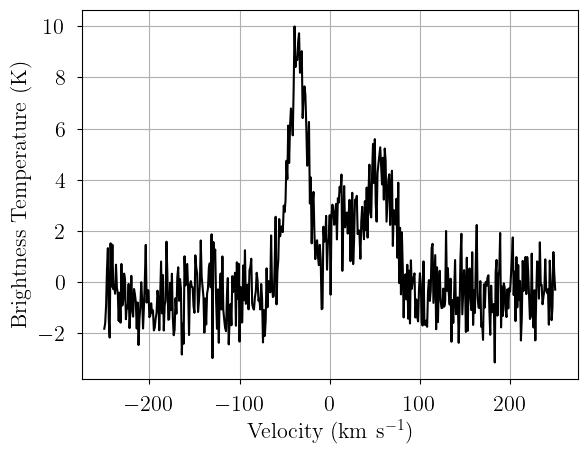

In [3]:
from bayes_spec.models import GaussLineNoise

# Initialize and define the model
model = GaussLineNoise(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "rms_observation": 1.0, # spectral rms (K)
    "observation_baseline_norm": [-0.5, 0.2, 0.05], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [5]:
model = GaussLineNoise(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

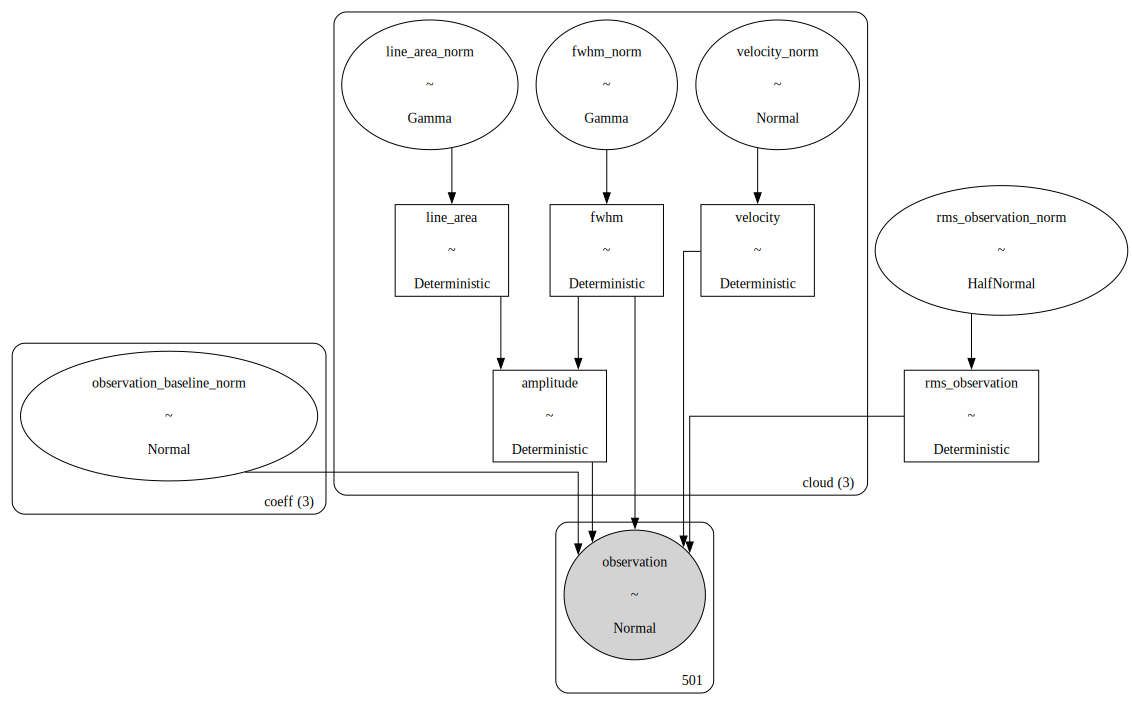

In [6]:
# Plot model graph
model.plot_graph(f"{figdir}/model_noise.gv", "svg")
SVG(f"{figdir}/model_noise.gv.{ext}")

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_norm]


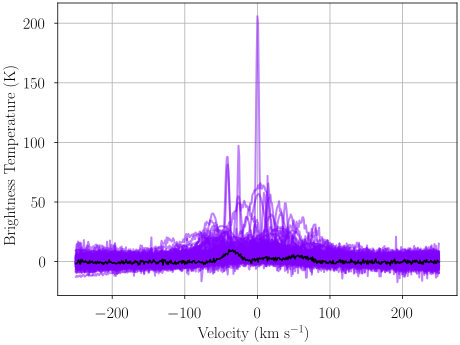

In [7]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive_noise.{ext}",
)
SVG(f"{figdir}/prior_predictive_noise.{ext}")

## Posterior Sampling: MCMC

In [8]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4000
Interrupted at 3,999 [3%]: Average Loss = 1,058.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Only 3 chains appear converged.


In [9]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [10]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],9.317,0.302,8.778,9.910,0.005,0.004,3516.0,1928.0,1.00
amplitude[1],4.901,0.306,4.329,5.431,0.008,0.006,1814.0,1368.0,1.00
amplitude[2],3.334,0.281,2.845,3.885,0.006,0.004,2531.0,2471.0,1.00
fwhm[0],25.715,1.097,23.724,27.847,0.023,0.017,2193.0,2258.0,1.00
fwhm[1],34.102,3.270,27.939,40.198,0.094,0.067,1175.0,1534.0,1.00
fwhm[2],34.445,6.717,23.772,46.818,0.241,0.175,941.0,901.0,1.01
fwhm_norm[0],0.857,0.037,0.791,0.928,0.001,0.001,2193.0,2258.0,1.00
fwhm_norm[1],1.137,0.109,0.931,1.340,0.003,0.002,1175.0,1534.0,1.00
fwhm_norm[2],1.148,0.224,0.792,1.561,0.008,0.006,941.0,901.0,1.01
line_area[0],254.912,10.811,234.815,275.794,0.254,0.180,1852.0,1744.0,1.00


Sampling: [observation]


Output()

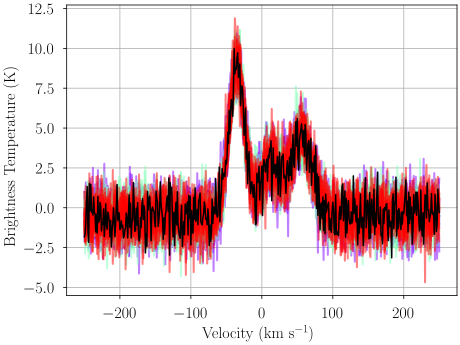

In [11]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_noise.{ext}"
)
SVG(f"{figdir}/posterior_predictive_noise.{ext}")

In [12]:
model.plot_traces(f"{figdir}/traces_noise.{ext}")
SVG(f"{figdir}/traces_noise.{ext}")